https://github.com/iolucas/dlnd-projects/blob/master/image-classification/dlnd_image_classification.ipynb


In [1]:
import math
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline
import os
from collections import Counter

from sklearn.model_selection import train_test_split

from data_manager import load_dataset

import json

import psycopg2

import random

In [14]:
save key_to_int dict to be used to generate onehots
ensure strokes are in order (check if there is any time issue)
convert strokes to numpy arrays

use sketchrnn methods to classify things here

convert strokes to match (deltaX, deltaY, is_drawing, is_moving, is_finished)

SyntaxError: invalid syntax (<ipython-input-14-6bd1f182b00c>, line 1)

In [3]:
class StrokesDataset:
    def __init__(self):
        #Connect to db
        self.conn = psycopg2.connect("dbname='postgres' user='postgres' host='localhost' password='lucas'")
        self.cur = self.conn.cursor()
        
        #Retrieve and cache ids list
        self.cur.execute("SELECT id FROM samples LIMIT 300000")
        id_list = self.cur.fetchall()
        self.id_cache = [id_value[0] for id_value in id_list]
        
        #Retrieve and cache labels
        self.cur.execute("SELECT DISTINCT key FROM samples LIMIT 300000")
        self.key_list = [key_value[0] for key_value in self.cur.fetchall()]
        self.key_to_ind = dict([(key, ind) for ind, key in enumerate(self.key_list)])
        
    def get_train_valid_test_ids(self):
        train_ids, valid_ids = train_test_split(self.id_cache, test_size=0.4)
        valid_ids, test_ids = train_test_split(valid_ids, test_size=0.5)
        return tuple(train_ids), tuple(valid_ids), tuple(test_ids)
    
    def get_batches(self, ids, batch_size):
        assert batch_size < 5000
        
        self.cur.execute("SELECT key, strokes FROM samples WHERE id in {}".format(ids))
       
        while True:
            data_batch = self.cur.fetchmany(batch_size)
            if len(data_batch) == 0:
                break
                
            ziped = list(zip(*data_batch)) #Use zip to separate labels from datapoints
            
            yield ziped[1], ziped[0]        

In [4]:
def draw_image(strokes_list):
    im = Image.new(mode="1", size=(500,500))

    draw = ImageDraw.Draw(im)
    #draw.moveTo(strokes[0][:2], fill=128)
    #print(strokes)
    #draw.line((0, 0) + im.size, fill=128)
    #draw.line((0, im.size[1], im.size[0], 0), fill=128)
    for strokes in strokes_list:
        draw.line(strokes, fill=128, width=5)
    
    
    #for stroke in strokes[0:]:
        #print(stroke.tolist())
        #draw.line(stroke, fill=128, width=10)

    plt.imshow(im)

# write to stdout
#im.save(sys.stdout, "PNG")

In [5]:
def gen_tuples(strokes_list):
    strokes_group = list()
    for strokes in strokes_list:
        strokes_tuples = list()
        for x,y,t in strokes:
            strokes_tuples.append((x,y))
        strokes_group.append(strokes_tuples)
    return strokes_group

In [6]:
def gen_random_tuple(size):
    assert size < 100000
    rand_list = list()
    while len(rand_list) < size:
        rand_value = random.randint(1,50000)
        if rand_value not in rand_list:
            rand_list.append(rand_value)
        
    return tuple(rand_list)

In [7]:
ds = StrokesDataset()

In [8]:
ds.key_to_ind[ds.key_list[0]]

0

In [9]:
sets = ds.get_train_valid_test_ids()

Wall time: 8.19 s


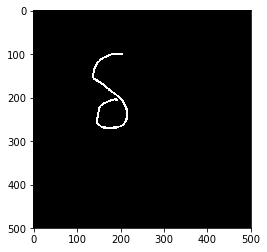

In [10]:
%time test_batch = next(ds.get_batches(sets[0],1000))
draw_image(gen_tuples(test_batch[0][59]))

In [121]:


def transform_data(batch):
    """Convert strokes to match (deltaX, deltaY, is_drawing, is_moving, is_finished)"""
    
    #Gen pen moving onehots
    onehots = list()
    for strokes in batch:
        strokes_onehots = [[0,1,0]] + [[1,0,0]]*(len(strokes)-1)
        onehots += strokes_onehots
        
    onehots[-1] = [0,0,1]
    
    #Reshape strokes lists
    flatten_strokes = [[0,0,0]]
    for strokes in batch:
        flatten_strokes += strokes
        
    flatten_strokes = np.array(flatten_strokes)
    #Get delta values
    delta_strokes = flatten_strokes[1:] - flatten_strokes[:-1]
    
    np_batch = np.concatenate((delta_strokes[:,:2], onehots), axis=1)
    
    return np_batch.astype(int)
    
%time transform_data(test_batch[0][600])
#draw_image(gen_tuples(test_batch[0][600]))

Wall time: 0 ns


array([[  98,  126,    0,    1,    0],
       [   0,    0,    1,    0,    0],
       [   3,    4,    1,    0,    0],
       [   1,    2,    1,    0,    0],
       [   2,    1,    1,    0,    0],
       [   3,    5,    1,    0,    0],
       [   2,    3,    1,    0,    0],
       [   3,    3,    1,    0,    0],
       [   6,    8,    1,    0,    0],
       [   4,    5,    1,    0,    0],
       [   4,    5,    1,    0,    0],
       [   7,    9,    1,    0,    0],
       [   4,    4,    1,    0,    0],
       [   4,    4,    1,    0,    0],
       [   7,    8,    1,    0,    0],
       [   8,   10,    1,    0,    0],
       [   5,    5,    1,    0,    0],
       [   4,    4,    1,    0,    0],
       [   8,    8,    1,    0,    0],
       [   4,    4,    1,    0,    0],
       [   4,    4,    1,    0,    0],
       [   6,    6,    1,    0,    0],
       [   3,    4,    1,    0,    0],
       [   6,    7,    1,    0,    0],
       [   2,    3,    1,    0,    0],
       [   2,    3,    1,

In [116]:

%time sorted(test_batch[0][0][0], key=lambda a: a.__getitem__(2), reverse=False)[:5]

Wall time: 0 ns


[[250, 103, 1362942716695],
 [242, 103, 1362942716985],
 [237, 103, 1362942717001],
 [231, 104, 1362942717018],
 [225, 107, 1362942717036]]

In [47]:
test_batch[0][0][0][:5]

[[250, 103, 1362942716695],
 [242, 103, 1362942716985],
 [237, 103, 1362942717001],
 [231, 104, 1362942717018],
 [225, 107, 1362942717036]]

In [11]:
#imgs, labels, int2sym = load_dataset(10)

In [12]:
#test_ind = 90000
#plt.imshow(imgs[test_ind])
#print(int2sym[labels[test_ind]])

In [13]:
tf.reset_default_graph()

n_symbols = 82

inputs = tf.placeholder(tf.float32, shape=[None, 45,45])
inputs_flatten = tf.reshape(inputs, shape=[-1,45*45])
targets = tf.placeholder(tf.int32, shape=[None])

targets_onehot = tf.one_hot(targets, n_symbols)

#h1 = tf.layers.dense(inputs_flatten, 3000, activation=tf.nn.relu)
h2 = tf.layers.dense(inputs_flatten, 1000, activation=tf.nn.relu)
h3 = tf.layers.dense(h2, 500, activation=tf.nn.relu)
logits = tf.layers.dense(h3, n_symbols)
output = tf.nn.softmax(logits)

sc = tf.nn.softmax_cross_entropy_with_logits(labels=targets_onehot, logits=logits)

cost = tf.reduce_mean(sc)

optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(targets_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [8]:
#dir(conn)

In [102]:
os.listdir("../detexify data")

['detexify.sql', 'detexify.sql.gz', 'README.txt', 'symbols.json']

In [139]:
symbols = json.load(open("../detexify data/symbols.json"))
symbols_dict = dict([(sym['id'],sym['command']) for sym in symbols])

In [150]:
from IPython.display import display, Math, Latex
a = symbols_dict['latex2e-OT1-_textasciicircum']
display(Latex(a))

<IPython.core.display.Latex object>

In [137]:
%%latex

$$\rightleftharpoons$$

<IPython.core.display.Latex object>

In [138]:
symbols

[{'command': '\\textasciicircum',
  'css_class': 'symbol0fc0a6460b919255cae7741740fcfcdb',
  'id': 'latex2e-OT1-_textasciicircum',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textless',
  'css_class': 'symbol8d5aed0bf13f89286d7d600bd3b6f998',
  'id': 'latex2e-OT1-_textless',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textasciitilde',
  'css_class': 'symbol46c29390c9cf916a34a9748ecb44b59e',
  'id': 'latex2e-OT1-_textasciitilde',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textordfeminine',
  'css_class': 'symbol9622c859e6bcde47476d601346929164',
  'id': 'latex2e-OT1-_textordfeminine',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textasteriskcentered',
  'css_class': 'symbol64973858a2e540a38ac594805ae83cd8',
  'id': 'latex2e-OT1-_textasteriskcentered',
  'mathmode': False,
  'textmode': True},
 {'command': '\\textordmasculine',
  'css_class': 'symbol970176e9a7af129519e6cbda104b6937',
  'id': 'latex2e-OT1-_textordmasculine',
  'mathm

<style>
h2:after {
    content: '\\texthtc';
}
</style> <h2></h2>

In [115]:
from IPython.core.display import display, HTML
display(HTML(' <style>
h2:after {
    content: ' \00A7';
}
</style> <h2></h2>'))

SyntaxError: EOL while scanning string literal (<ipython-input-115-0a2445698c59>, line 2)

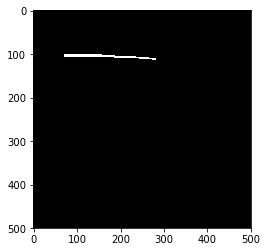

In [127]:
#gen_tuples(rows[0][2][0])
draw_image(gen_tuples(rows[57][2][0]))
#draw_image([[0,0], [100,0], (0,100)])

In [122]:
rows[1]

(8250,
 'latex2e-OT1-_delta',
 [[[232, 93, 1315344284739],
   [232, 92, 1315344284924],
   [232, 91, 1315344284957],
   [231, 90, 1315344284982],
   [229, 88, 1315344284997],
   [224, 81, 1315344285031],
   [217, 74, 1315344285064],
   [207, 68, 1315344285097],
   [197, 65, 1315344285132],
   [186, 63, 1315344285164],
   [182, 63, 1315344285216],
   [174, 63, 1315344285249],
   [170, 66, 1315344285282],
   [167, 72, 1315344285315],
   [166, 78, 1315344285349],
   [166, 87, 1315344285382],
   [172, 97, 1315344285416],
   [179, 105, 1315344285450],
   [191, 121, 1315344285484],
   [203, 133, 1315344285517],
   [214, 148, 1315344285551],
   [220, 158, 1315344285584],
   [225, 165, 1315344285617],
   [227, 170, 1315344285649],
   [227, 176, 1315344285685],
   [227, 183, 1315344285718],
   [226, 187, 1315344285752],
   [224, 191, 1315344285785],
   [220, 196, 1315344285819],
   [212, 199, 1315344285852],
   [202, 201, 1315344285886],
   [192, 202, 1315344285919],
   [181, 203, 1315344285953